In [1]:
from funs import *
import os
import numpy as np
import pandas as pd
from PySpice.Spice.Xyce.Server import XyceServer
from lmfit import minimize, Parameters
import lmfit
import time
import pandas as pd
import csv
from scipy.interpolate import interp1d
from scipy.interpolate import InterpolatedUnivariateSpline

In [5]:
def get_points(data):

    vdd = 0.7
    v20 = 0.2 * vdd
    v80 = 0.8 * vdd
    v10 = 0.1 * vdd
    v90 = 0.9 * vdd
    data = list(zip(*data))
    time = np.array(data[0])
    Vout = np.array(data[1])

    f_interp = interp1d(Vout, time, kind='linear', fill_value='extrapolate')


    t20 = f_interp(v20)
    t80 = f_interp(v80)
    t10 = f_interp(v10)
    t90 = f_interp(v90)
    delay1 =t20-t80
    delay2 =t10-t90

    
    return [delay1,delay2]

In [24]:
df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]
df = df.apply(pd.to_numeric, errors='coerce')  
df.dropna(inplace=True)  
target_data = df.values
target_points = get_points(target_data)
target_points=np.array(target_points)
print(target_points)

[-1.66046708e-12 -2.72968375e-12]


C:\Users\y50046737\AppData\Local\Temp\ipykernel_2712\2859050186.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('netlist.sp.prn', delim_whitespace=True, skiprows=1, header=None)[[1, 4]]


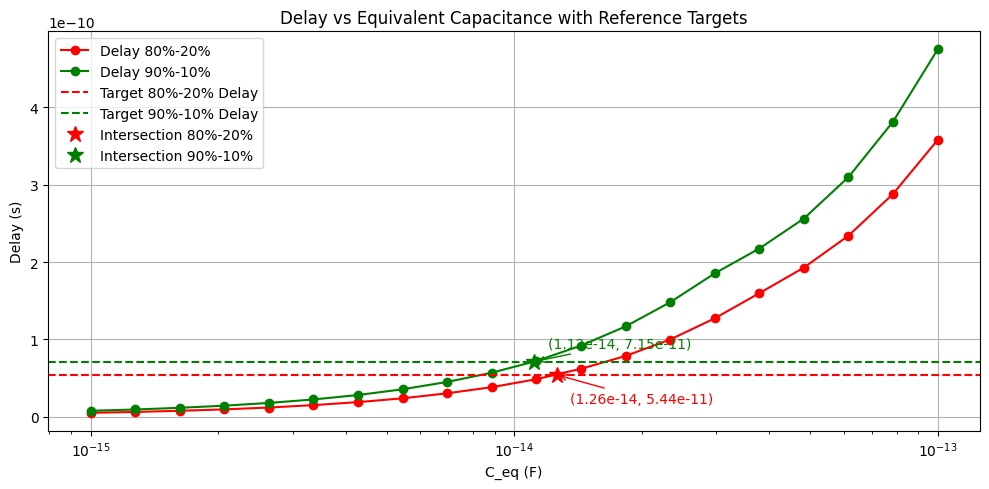

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# 假设你已经定义好了 run_tran_inv 和 get_points 函数

C_eq_list = np.logspace(-15, -13, 20)

all_delay = []
for C_eq in C_eq_list:
    time, output_ = run_tran_inv(C_eq)
    time = np.array(time)
    output_ = 0.7 - np.array(output_)
    data = np.column_stack((time, output_))
    delay = get_points(data)
    all_delay.append(delay)

all_delay = np.array(all_delay)

ref_80_20 = 5.44318825e-11
ref_90_10 = 7.15168654e-11



# 插值：创建 delay vs C_eq 的插值函数
interp_80_20 = interp1d(all_delay[:, 0], C_eq_list, kind='linear', bounds_error=False, fill_value="extrapolate")
interp_90_10 = interp1d(all_delay[:, 1], C_eq_list, kind='linear', bounds_error=False, fill_value="extrapolate")

# 找交点坐标
cross_C_80_20 = float(interp_80_20(ref_80_20))
cross_C_90_10 = float(interp_90_10(ref_90_10))

# 反推对应点以显示
cross_point_80_20 = (cross_C_80_20, ref_80_20)
cross_point_90_10 = (cross_C_90_10, ref_90_10)

# 绘图
plt.figure(figsize=(10, 5))
plt.plot(C_eq_list, all_delay[:, 0],'ro-', label='Delay 80%-20%')
plt.plot(C_eq_list, all_delay[:, 1], 'go-', label='Delay 90%-10%')
plt.axhline(ref_80_20, color='red', linestyle='--', label='Target 80%-20% Delay')
plt.axhline(ref_90_10, color='green', linestyle='--', label='Target 90%-10% Delay')

# 标注交点
plt.plot(*cross_point_80_20, 'r*', markersize=12, label='Intersection 80%-20%')
plt.plot(*cross_point_90_10, 'g*', markersize=12, label='Intersection 90%-10%')

plt.annotate(f"({cross_point_80_20[0]:.2e}, {cross_point_80_20[1]:.2e})",
             xy=cross_point_80_20, xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red'), color='red')

plt.annotate(f"({cross_point_90_10[0]:.2e}, {cross_point_90_10[1]:.2e})",
             xy=cross_point_90_10, xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='green'), color='green')

plt.xscale('log')
plt.xlabel('C_eq (F)')
plt.ylabel('Delay (s)')
plt.title('Delay vs Equivalent Capacitance with Reference Targets')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


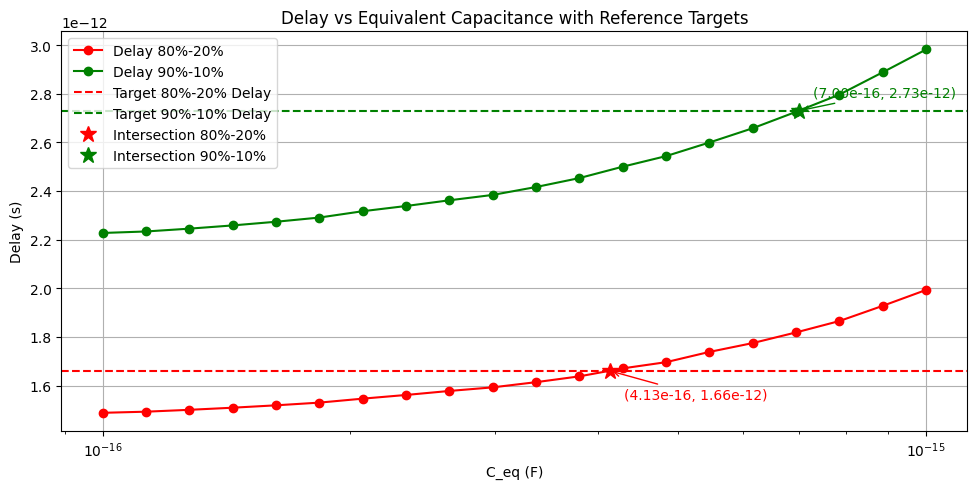

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



C_eq_list = np.logspace(-16, -15, 20)

all_delay = []
for C_eq in C_eq_list:
    time, output_ = run_tran(C_eq)
    time = np.array(time)
    output_ = 0.7 - np.array(output_)
    data = np.column_stack((time, output_))
    delay = get_points(data)
    all_delay.append(delay)

all_delay = np.array(all_delay)
#[-1.66046708e-12 -2.72968375e-12]

ref_80_20 = 1.66046708e-12
ref_90_10 = 2.72968375e-12



interp_80_20 = interp1d(all_delay[:, 0], C_eq_list, kind='linear', bounds_error=False, fill_value="extrapolate")
interp_90_10 = interp1d(all_delay[:, 1], C_eq_list, kind='linear', bounds_error=False, fill_value="extrapolate")


cross_C_80_20 = float(interp_80_20(ref_80_20))
cross_C_90_10 = float(interp_90_10(ref_90_10))


cross_point_80_20 = (cross_C_80_20, ref_80_20)
cross_point_90_10 = (cross_C_90_10, ref_90_10)


plt.figure(figsize=(10, 5))
plt.plot(C_eq_list, all_delay[:, 0],'ro-', label='Delay 80%-20%')
plt.plot(C_eq_list, all_delay[:, 1], 'go-', label='Delay 90%-10%')
plt.axhline(ref_80_20, color='red', linestyle='--', label='Target 80%-20% Delay')
plt.axhline(ref_90_10, color='green', linestyle='--', label='Target 90%-10% Delay')


plt.plot(*cross_point_80_20, 'r*', markersize=12, label='Intersection 80%-20%')
plt.plot(*cross_point_90_10, 'g*', markersize=12, label='Intersection 90%-10%')

plt.annotate(f"({cross_point_80_20[0]:.2e}, {cross_point_80_20[1]:.2e})",
             xy=cross_point_80_20, xytext=(10, -20), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='red'), color='red')

plt.annotate(f"({cross_point_90_10[0]:.2e}, {cross_point_90_10[1]:.2e})",
             xy=cross_point_90_10, xytext=(10, 10), textcoords='offset points',
             arrowprops=dict(arrowstyle="->", color='green'), color='green')

plt.xscale('log')
plt.xlabel('C_eq (F)')
plt.ylabel('Delay (s)')
plt.title('Delay vs Equivalent Capacitance with Reference Targets')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()